# Improved E-Waste Classification System

This notebook provides an improved version of the E-Waste Classification System with enhanced training strategies and better performance.

## Key Improvements:
1. **Better Data Preprocessing**: Enhanced normalization and augmentation
2. **Improved Model Architecture**: Better regularization and layer configuration
3. **Advanced Training Strategy**: Progressive unfreezing and learning rate scheduling
4. **Enhanced Callbacks**: Better monitoring and early stopping
5. **Data Quality Checks**: Validation of input data
6. **Material Composition Estimator**: Novel feature for estimating material composition

## 📋 Table of Contents
1. [Setup and Configuration](#setup)
2. [Data Quality Analysis](#data-quality)
3. [Enhanced Data Preprocessing](#data-preprocessing)
4. [Improved Model Building](#model-building)
5. [Progressive Training Strategy](#training-strategy)
6. [Model Evaluation](#model-evaluation)
7. [Prediction Examples](#prediction-examples)
8. [Material Composition Estimator](#material-composition)

## 1. Setup and Configuration {#setup}

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Scikit-learn imports
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

✅ Libraries imported successfully!
TensorFlow version: 2.19.0
GPU Available: []


In [2]:
# Enhanced configuration with better hyperparameters
config = {
    'model': {
        'name': 'EfficientNetV2B0',
        'input_shape': [224, 224, 3],
        'num_classes': 10,
        'weights': 'imagenet',
        'dropout_rate': 0.3,
        'l2_reg': 1e-4
    },
    'training': {
        'batch_size': 16,  # Reduced for better gradient updates
        'initial_epochs': 15,  # Phase 1: frozen base
        'fine_tune_epochs': 25,  # Phase 2: unfrozen base
        'initial_learning_rate': 1e-3,
        'fine_tune_learning_rate': 1e-5,
        'early_stopping_patience': 8,
        'reduce_lr_patience': 4,
        'reduce_lr_factor': 0.3,
        'unfreeze_layers': 50  # Number of layers to unfreeze from top
    },
    'data': {
        'data_dir': 'E:\\E-Waste-Classification\\data\\modified-dataset',
        'target_size': (224, 224),
        'validation_split': 0.2,
        'augmentation': {
            'rotation_range': 30,
            'width_shift_range': 0.25,
            'height_shift_range': 0.25,
            'shear_range': 0.15,
            'zoom_range': 0.3,
            'horizontal_flip': True,
            'vertical_flip': False,
            'brightness_range': [0.8, 1.2],
            'fill_mode': 'nearest'
        }
    },
    'classes': [
        "Battery", "Keyboard", "Microwave", "Mobile", "Mouse",
        "PCB", "Player", "Printer", "Television", "Washing Machine"
    ]
}

print("📋 Enhanced Configuration loaded:")
print(f"   Model: {config['model']['name']}")
print(f"   Classes: {len(config['classes'])}")
print(f"   Input Shape: {config['model']['input_shape']}")
print(f"   Batch Size: {config['training']['batch_size']}")
print(f"   Initial Epochs: {config['training']['initial_epochs']}")
print(f"   Fine-tune Epochs: {config['training']['fine_tune_epochs']}")
print(f"   Dataset Path: {config['data']['data_dir']}")

📋 Enhanced Configuration loaded:
   Model: EfficientNetV2B0
   Classes: 10
   Input Shape: [224, 224, 3]
   Batch Size: 16
   Initial Epochs: 15
   Fine-tune Epochs: 25
   Dataset Path: E:\E-Waste-Classification\data\modified-dataset


## 2. Data Quality Analysis {#data-quality}

Analyze data quality and distribution to identify potential issues.

In [3]:
def analyze_image_quality(data_dir, sample_size=5):
    """Analyze image quality and characteristics."""
    print("🔍 Analyzing image quality...")
    
    image_stats = []
    
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(data_dir, split)
        if not os.path.exists(split_path):
            continue
            
        for class_name in config['classes']:
            class_path = os.path.join(split_path, class_name)
            if not os.path.exists(class_path):
                continue
                
            image_files = [f for f in os.listdir(class_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            
            # Sample a few images for analysis
            sample_files = np.random.choice(image_files, 
                                          min(sample_size, len(image_files)), 
                                          replace=False)
            
            for img_file in sample_files:
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path)
                    img_array = np.array(img)
                    
                    stats = {
                        'split': split,
                        'class': class_name,
                        'width': img.width,
                        'height': img.height,
                        'channels': len(img_array.shape),
                        'mean_intensity': np.mean(img_array),
                        'std_intensity': np.std(img_array),
                        'min_intensity': np.min(img_array),
                        'max_intensity': np.max(img_array)
                    }
                    image_stats.append(stats)
                    
                except Exception as e:
                    print(f"⚠️  Error processing {img_path}: {e}")
    
    df_stats = pd.DataFrame(image_stats)
    
    print(f"\n📊 Image Quality Analysis:")
    print(f"   Analyzed {len(df_stats)} images")
    print(f"   Average dimensions: {df_stats['width'].mean():.0f} x {df_stats['height'].mean():.0f}")
    print(f"   Mean intensity: {df_stats['mean_intensity'].mean():.2f} ± {df_stats['mean_intensity'].std():.2f}")
    print(f"   Intensity range: [{df_stats['min_intensity'].min()}, {df_stats['max_intensity'].max()}]")
    
    return df_stats

# Analyze image quality
image_stats = analyze_image_quality(config['data']['data_dir'])

🔍 Analyzing image quality...

📊 Image Quality Analysis:
   Analyzed 150 images
   Average dimensions: 150 x 150
   Mean intensity: 143.91 ± 51.33
   Intensity range: [0, 255]


## 3. Enhanced Data Preprocessing {#data-preprocessing}

Implement improved data preprocessing with better normalization and augmentation.

In [4]:
# Enhanced data generators with better preprocessing
print("🔄 Setting up enhanced data generators...")

# Custom preprocessing function
def preprocess_input_custom(x):
    """Custom preprocessing function."""
    # Normalize to [0, 1]
    x = x / 255.0
    # Apply ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    x = (x - mean) / std
    return x

# Training data generator with enhanced augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_custom,
    rotation_range=config['data']['augmentation']['rotation_range'],
    width_shift_range=config['data']['augmentation']['width_shift_range'],
    height_shift_range=config['data']['augmentation']['height_shift_range'],
    shear_range=config['data']['augmentation']['shear_range'],
    zoom_range=config['data']['augmentation']['zoom_range'],
    horizontal_flip=config['data']['augmentation']['horizontal_flip'],
    vertical_flip=config['data']['augmentation']['vertical_flip'],
    brightness_range=config['data']['augmentation']['brightness_range'],
    fill_mode=config['data']['augmentation']['fill_mode']
)

# Validation and test data generators (no augmentation)
val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input_custom
)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(config['data']['data_dir'], 'train'),
    target_size=config['data']['target_size'],
    batch_size=config['training']['batch_size'],
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(config['data']['data_dir'], 'val'),
    target_size=config['data']['target_size'],
    batch_size=config['training']['batch_size'],
    class_mode='categorical',
    shuffle=False,
    seed=42
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(config['data']['data_dir'], 'test'),
    target_size=config['data']['target_size'],
    batch_size=config['training']['batch_size'],
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print("✅ Enhanced data generators created successfully!")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {val_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Number of classes: {train_generator.num_classes}")
print(f"   Class indices: {train_generator.class_indices}")

# Calculate class weights for balanced training
class_labels = []
for i in range(len(config['classes'])):
    class_labels.extend([i] * (train_generator.samples // len(config['classes'])))

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weight_dict = dict(enumerate(class_weights))

print(f"\n⚖️  Class weights calculated for balanced training:")
for i, weight in class_weight_dict.items():
    print(f"   {config['classes'][i]}: {weight:.3f}")

🔄 Setting up enhanced data generators...
Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
✅ Enhanced data generators created successfully!
   Training samples: 2400
   Validation samples: 300
   Test samples: 300
   Number of classes: 10
   Class indices: {'Battery': 0, 'Keyboard': 1, 'Microwave': 2, 'Mobile': 3, 'Mouse': 4, 'PCB': 5, 'Player': 6, 'Printer': 7, 'Television': 8, 'Washing Machine': 9}

⚖️  Class weights calculated for balanced training:
   Battery: 1.000
   Keyboard: 1.000
   Microwave: 1.000
   Mobile: 1.000
   Mouse: 1.000
   PCB: 1.000
   Player: 1.000
   Printer: 1.000
   Television: 1.000
   Washing Machine: 1.000


## 4. Improved Model Building {#model-building}

Build an enhanced model with better architecture and regularization.

In [5]:
def build_improved_model(config):
    """
    Build an improved EfficientNetV2B0 model with better regularization.
    """
    print("🏗️  Building improved EfficientNetV2B0 model...")
    
    # Input layer
    input_tensor = layers.Input(shape=config['model']['input_shape'])
    
    # Base model (EfficientNetV2B0)
    base_model = EfficientNetV2B0(
        weights=config['model']['weights'],
        include_top=False,
        input_tensor=input_tensor
    )
    
    # Freeze base model layers initially
    base_model.trainable = False
    
    # Add improved classification head
    x = base_model.output
    
    # Global pooling with both average and max pooling
    avg_pool = layers.GlobalAveragePooling2D()(x)
    max_pool = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([avg_pool, max_pool])
    
    # First dense block
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(config['model']['dropout_rate'])(x)
    x = layers.Dense(
        512, 
        activation='relu',
        kernel_regularizer=l2(config['model']['l2_reg'])
    )(x)
    
    # Second dense block
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(config['model']['dropout_rate'] * 0.7)(x)
    x = layers.Dense(
        256, 
        activation='relu',
        kernel_regularizer=l2(config['model']['l2_reg'])
    )(x)
    
    # Third dense block
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(config['model']['dropout_rate'] * 0.5)(x)
    x = layers.Dense(
        128, 
        activation='relu',
        kernel_regularizer=l2(config['model']['l2_reg'])
    )(x)
    
    # Output layer
    x = layers.Dropout(config['model']['dropout_rate'] * 0.3)(x)
    predictions = layers.Dense(
        config['model']['num_classes'], 
        activation='softmax',
        name='predictions',
        kernel_regularizer=l2(config['model']['l2_reg'])
    )(x)
    
    # Create the model
    model = models.Model(inputs=input_tensor, outputs=predictions)
    
    return model, base_model

# Build the improved model
model, base_model = build_improved_model(config)

# Compile the model for initial training
model.compile(
    optimizer=Adam(learning_rate=config['training']['initial_learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print("✅ Improved model built and compiled successfully!")
print(f"\n📊 Model Summary:")
print(f"   Total parameters: {model.count_params():,}")
print(f"   Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")
print(f"   Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights]):,}")

# Display model architecture summary
print(f"\n🏗️  Model Architecture:")
model.summary()

🏗️  Building improved EfficientNetV2B0 model...
✅ Improved model built and compiled successfully!

📊 Model Summary:
   Total parameters: 7,409,370
   Trainable parameters: 1,483,402
   Non-trainable parameters: 5,925,968

🏗️  Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 7,409,370 (28.26 MB)

 Trainable params: 1,483,402 (5.66 MB)

 Non-trainable params: 5,925,968 (22.61 MB)

## 5. Progressive Training Strategy {#training-strategy}

Implement a two-phase training strategy: frozen base model first, then fine-tuning.

In [6]:
# Phase 1: Train with frozen base model
print("🚀 Phase 1: Training with frozen base model...")

# Set up callbacks for phase 1
callbacks_phase1 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=config['training']['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=config['training']['reduce_lr_factor'],
        patience=config['training']['reduce_lr_patience'],
        min_lr=1e-7,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_model_phase1.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

# Calculate steps
steps_per_epoch = train_generator.samples // config['training']['batch_size']
validation_steps = val_generator.samples // config['training']['batch_size']

print(f"   Training for {config['training']['initial_epochs']} epochs")
print(f"   Steps per epoch: {steps_per_epoch}")
print(f"   Validation steps: {validation_steps}")
print(f"   Learning rate: {config['training']['initial_learning_rate']}")

# Train phase 1
history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=config['training']['initial_epochs'],
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_phase1,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✅ Phase 1 training completed!")
print(f"   Best validation accuracy: {max(history_phase1.history['val_accuracy']):.4f}")

🚀 Phase 1: Training with frozen base model...
   Training for 15 epochs
   Steps per epoch: 150
   Validation steps: 18
   Learning rate: 0.001
Epoch 1/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2024 - loss: 2.5832 - top_3_accuracy: 0.4661
Epoch 1: val_accuracy improved from -inf to 0.37153, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.2027 - loss: 2.5818 - top_3_accuracy: 0.4666 - val_accuracy: 0.3715 - val_loss: 1.9146 - val_top_3_accuracy: 0.6875 - learning_rate: 0.0010
Epoch 2/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2975 - loss: 2.1577 - top_3_accuracy: 0.5818
Epoch 2: val_accuracy did not improve from 0.37153
150/150 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.2975 - loss: 2.1577 - top_3_accuracy: 0.5818 - val_accuracy: 0.3681 - val_loss: 1.8678 - val_top_3_accuracy: 0.6840 - learning_rate: 0.0010
Epoch 3/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3276 - loss: 2.0932 - top_3_accuracy: 0.6343
Epoch 3: val_accuracy improved from 0.37153 to 0.46875, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.3276 - loss: 2.0931 - top_3_accuracy: 0.6343 - val_accuracy: 0.4688 - val_loss: 1.6400 - val_top_3_accuracy: 0.7882 - learning_rate: 0.0010
Epoch 4/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3251 - loss: 2.0338 - top_3_accuracy: 0.6353
Epoch 4: val_accuracy improved from 0.46875 to 0.50000, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.3253 - loss: 2.0335 - top_3_accuracy: 0.6354 - val_accuracy: 0.5000 - val_loss: 1.5472 - val_top_3_accuracy: 0.8333 - learning_rate: 0.0010
Epoch 5/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3837 - loss: 1.9290 - top_3_accuracy: 0.6891
Epoch 5: val_accuracy did not improve from 0.50000
150/150 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.3838 - loss: 1.9291 - top_3_accuracy: 0.6890 - val_accuracy: 0.4861 - val_loss: 1.5190 - val_top_3_accuracy: 0.8403 - learning_rate: 0.0010
Epoch 6/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3895 - loss: 1.8940 - top_3_accuracy: 0.6941
Epoch 6: val_accuracy improved from 0.50000 to 0.54167, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.3894 - loss: 1.8942 - top_3_accuracy: 0.6941 - val_accuracy: 0.5417 - val_loss: 1.4403 - val_top_3_accuracy: 0.8333 - learning_rate: 0.0010
Epoch 7/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3798 - loss: 1.9143 - top_3_accuracy: 0.6821
Epoch 7: val_accuracy improved from 0.54167 to 0.58681, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.3798 - loss: 1.9144 - top_3_accuracy: 0.6820 - val_accuracy: 0.5868 - val_loss: 1.4394 - val_top_3_accuracy: 0.8472 - learning_rate: 0.0010
Epoch 8/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4010 - loss: 1.8313 - top_3_accuracy: 0.6970
Epoch 8: val_accuracy did not improve from 0.58681
150/150 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.4009 - loss: 1.8315 - top_3_accuracy: 0.6969 - val_accuracy: 0.5764 - val_loss: 1.3674 - val_top_3_accuracy: 0.8785 - learning_rate: 0.0010
Epoch 9/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4038 - loss: 1.8700 - top_3_accuracy: 0.7042
Epoch 9: val_accuracy improved from 0.58681 to 0.60069, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.4037 - loss: 1.8700 - top_3_accuracy: 0.7041 - val_accuracy: 0.6007 - val_loss: 1.3875 - val_top_3_accuracy: 0.8715 - learning_rate: 0.0010
Epoch 10/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - accuracy: 0.4059 - loss: 1.8172 - top_3_accuracy: 0.7245
Epoch 10: val_accuracy improved from 0.60069 to 0.62153, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.4060 - loss: 1.8173 - top_3_accuracy: 0.7244 - val_accuracy: 0.6215 - val_loss: 1.3249 - val_top_3_accuracy: 0.8681 - learning_rate: 0.0010
Epoch 11/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 936ms/step - accuracy: 0.4124 - loss: 1.8505 - top_3_accuracy: 0.7209
Epoch 11: val_accuracy improved from 0.62153 to 0.62847, saving model to best_model_phase1.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.4124 - loss: 1.8506 - top_3_accuracy: 0.7209 - val_accuracy: 0.6285 - val_loss: 1.3091 - val_top_3_accuracy: 0.8958 - learning_rate: 0.0010
Epoch 12/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4492 - loss: 1.7790 - top_3_accuracy: 0.7171
Epoch 12: val_accuracy did not improve from 0.62847
150/150 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.4491 - loss: 1.7792 - top_3_accuracy: 0.7171 - val_accuracy: 0.6285 - val_loss: 1.2498 - val_top_3_accuracy: 0.8924 - learning_rate: 0.0010
Epoch 13/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 943ms/step - accuracy: 0.4398 - loss: 1.7989 - top_3_accuracy: 0.7237
Epoch 13: val_accuracy did not improve from 0.62847
150/150 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.4399 - loss: 1.7988 - top_3_accuracy: 0.7237 - val_accuracy: 0.5868 - val_loss: 1.3742 - val_top_3_accuracy: 0.8646 - learning_rate: 0.0010
Epoch 14/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4656 - loss: 1.73

150/150 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.4655 - loss: 1.7387 - top_3_accuracy: 0.7553 - val_accuracy: 0.6389 - val_loss: 1.2776 - val_top_3_accuracy: 0.8785 - learning_rate: 0.0010
Epoch 15/15
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.4378 - loss: 1.7953 - top_3_accuracy: 0.7484
Epoch 15: val_accuracy did not improve from 0.63889
150/150 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.4379 - loss: 1.7953 - top_3_accuracy: 0.7483 - val_accuracy: 0.6250 - val_loss: 1.2903 - val_top_3_accuracy: 0.9062 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 14.

✅ Phase 1 training completed!
   Best validation accuracy: 0.6389


In [7]:
# Phase 2: Fine-tune with unfrozen layers
print("🔥 Phase 2: Fine-tuning with unfrozen layers...")

# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze the bottom layers, unfreeze the top layers
for layer in base_model.layers[:-config['training']['unfreeze_layers']]:
    layer.trainable = False

print(f"   Unfrozen top {config['training']['unfreeze_layers']} layers")
print(f"   Total layers in base model: {len(base_model.layers)}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=config['training']['fine_tune_learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print(f"   New trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

# Set up callbacks for phase 2
callbacks_phase2 = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=config['training']['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=config['training']['reduce_lr_factor'],
        patience=config['training']['reduce_lr_patience'],
        min_lr=1e-8,
        verbose=1,
        mode='max'
    ),
    ModelCheckpoint(
        'best_model_final.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max'
    )
]

print(f"   Fine-tuning for {config['training']['fine_tune_epochs']} epochs")
print(f"   Learning rate: {config['training']['fine_tune_learning_rate']}")

# Train phase 2
history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=config['training']['fine_tune_epochs'],
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_phase2,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n✅ Phase 2 fine-tuning completed!")
print(f"   Best validation accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

🔥 Phase 2: Fine-tuning with unfrozen layers...
   Unfrozen top 50 layers
   Total layers in base model: 270
   New trainable parameters: 3,440,282
   Fine-tuning for 25 epochs
   Learning rate: 1e-05
Epoch 1/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2306 - loss: 2.7913 - top_3_accuracy: 0.4996
Epoch 1: val_accuracy improved from -inf to 0.36458, saving model to best_model_final.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.2305 - loss: 2.7910 - top_3_accuracy: 0.4996 - val_accuracy: 0.3646 - val_loss: 2.1119 - val_top_3_accuracy: 0.6493 - learning_rate: 1.0000e-05
Epoch 2/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2388 - loss: 2.5504 - top_3_accuracy: 0.5300
Epoch 2: val_accuracy improved from 0.36458 to 0.43403, saving model to best_model_final.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 286s 2s/step - accuracy: 0.2389 - loss: 2.5499 - top_3_accuracy: 0.5301 - val_accuracy: 0.4340 - val_loss: 1.9343 - val_top_3_accuracy: 0.7153 - learning_rate: 1.0000e-05
Epoch 3/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2708 - loss: 2.4643 - top_3_accuracy: 0.5552
Epoch 3: val_accuracy improved from 0.43403 to 0.46528, saving model to best_model_final.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.2709 - loss: 2.4639 - top_3_accuracy: 0.5553 - val_accuracy: 0.4653 - val_loss: 1.8386 - val_top_3_accuracy: 0.7674 - learning_rate: 1.0000e-05
Epoch 4/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3030 - loss: 2.3309 - top_3_accuracy: 0.5838
Epoch 4: val_accuracy did not improve from 0.46528
150/150 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3031 - loss: 2.3306 - top_3_accuracy: 0.5839 - val_accuracy: 0.4653 - val_loss: 1.7431 - val_top_3_accuracy: 0.7917 - learning_rate: 1.0000e-05
Epoch 5/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3076 - loss: 2.2658 - top_3_accuracy: 0.5893
Epoch 5: val_accuracy improved from 0.46528 to 0.49653, saving model to best_model_final.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.3077 - loss: 2.2655 - top_3_accuracy: 0.5894 - val_accuracy: 0.4965 - val_loss: 1.7134 - val_top_3_accuracy: 0.7917 - learning_rate: 1.0000e-05
Epoch 6/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3190 - loss: 2.1615 - top_3_accuracy: 0.6365
Epoch 6: val_accuracy did not improve from 0.49653
150/150 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.3190 - loss: 2.1617 - top_3_accuracy: 0.6364 - val_accuracy: 0.4653 - val_loss: 1.7087 - val_top_3_accuracy: 0.7951 - learning_rate: 1.0000e-05
Epoch 7/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3389 - loss: 2.1486 - top_3_accuracy: 0.6319
Epoch 7: val_accuracy did not improve from 0.49653
150/150 ━━━━━━━━━━━━━━━━━━━━ 227s 2s/step - accuracy: 0.3390 - loss: 2.1483 - top_3_accuracy: 0.6320 - val_accuracy: 0.4931 - val_loss: 1.7070 - val_top_3_accuracy: 0.7951 - learning_rate: 1.0000e-05
Epoch 8/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3368 - loss: 

150/150 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.3368 - loss: 2.1299 - top_3_accuracy: 0.6359 - val_accuracy: 0.5000 - val_loss: 1.6507 - val_top_3_accuracy: 0.7951 - learning_rate: 1.0000e-05
Epoch 9/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3413 - loss: 2.0877 - top_3_accuracy: 0.6318
Epoch 9: val_accuracy improved from 0.50000 to 0.52083, saving model to best_model_final.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.3413 - loss: 2.0877 - top_3_accuracy: 0.6319 - val_accuracy: 0.5208 - val_loss: 1.6178 - val_top_3_accuracy: 0.8021 - learning_rate: 1.0000e-05
Epoch 10/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3624 - loss: 2.0349 - top_3_accuracy: 0.6703
Epoch 10: val_accuracy improved from 0.52083 to 0.53125, saving model to best_model_final.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.3624 - loss: 2.0349 - top_3_accuracy: 0.6703 - val_accuracy: 0.5312 - val_loss: 1.5733 - val_top_3_accuracy: 0.8160 - learning_rate: 1.0000e-05
Epoch 11/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3657 - loss: 2.0310 - top_3_accuracy: 0.6455
Epoch 11: val_accuracy did not improve from 0.53125
150/150 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.3657 - loss: 2.0310 - top_3_accuracy: 0.6455 - val_accuracy: 0.5312 - val_loss: 1.5648 - val_top_3_accuracy: 0.8194 - learning_rate: 1.0000e-05
Epoch 12/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3773 - loss: 2.0485 - top_3_accuracy: 0.6596
Epoch 12: val_accuracy did not improve from 0.53125
150/150 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.3773 - loss: 2.0483 - top_3_accuracy: 0.6596 - val_accuracy: 0.5104 - val_loss: 1.6015 - val_top_3_accuracy: 0.8160 - learning_rate: 1.0000e-05
Epoch 13/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3697 - l

150/150 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.3697 - loss: 2.0126 - top_3_accuracy: 0.6557 - val_accuracy: 0.5521 - val_loss: 1.5423 - val_top_3_accuracy: 0.8194 - learning_rate: 1.0000e-05
Epoch 14/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4010 - loss: 1.9780 - top_3_accuracy: 0.6780
Epoch 14: val_accuracy did not improve from 0.55208
150/150 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.4009 - loss: 1.9781 - top_3_accuracy: 0.6779 - val_accuracy: 0.5521 - val_loss: 1.5352 - val_top_3_accuracy: 0.8368 - learning_rate: 1.0000e-05
Epoch 15/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3718 - loss: 1.9763 - top_3_accuracy: 0.6815
Epoch 15: val_accuracy did not improve from 0.55208
150/150 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.3719 - loss: 1.9763 - top_3_accuracy: 0.6815 - val_accuracy: 0.5521 - val_loss: 1.5088 - val_top_3_accuracy: 0.8333 - learning_rate: 1.0000e-05
Epoch 16/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3922 - l

150/150 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.3704 - loss: 1.9579 - top_3_accuracy: 0.6753 - val_accuracy: 0.5625 - val_loss: 1.5010 - val_top_3_accuracy: 0.8229 - learning_rate: 1.0000e-05
Epoch 18/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4165 - loss: 1.8959 - top_3_accuracy: 0.7128
Epoch 18: val_accuracy improved from 0.56250 to 0.57292, saving model to best_model_final.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.4164 - loss: 1.8961 - top_3_accuracy: 0.7127 - val_accuracy: 0.5729 - val_loss: 1.4991 - val_top_3_accuracy: 0.8403 - learning_rate: 1.0000e-05
Epoch 19/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4098 - loss: 1.8734 - top_3_accuracy: 0.7015
Epoch 19: val_accuracy did not improve from 0.57292
150/150 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.4097 - loss: 1.8737 - top_3_accuracy: 0.7014 - val_accuracy: 0.5556 - val_loss: 1.4893 - val_top_3_accuracy: 0.8472 - learning_rate: 1.0000e-05
Epoch 20/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3812 - loss: 1.9587 - top_3_accuracy: 0.6784
Epoch 20: val_accuracy did not improve from 0.57292
150/150 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.3812 - loss: 1.9586 - top_3_accuracy: 0.6785 - val_accuracy: 0.5660 - val_loss: 1.4866 - val_top_3_accuracy: 0.8438 - learning_rate: 1.0000e-05
Epoch 21/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3805 - l

150/150 ━━━━━━━━━━━━━━━━━━━━ 547s 4s/step - accuracy: 0.3806 - loss: 1.9227 - top_3_accuracy: 0.6904 - val_accuracy: 0.5764 - val_loss: 1.4706 - val_top_3_accuracy: 0.8368 - learning_rate: 1.0000e-05
Epoch 22/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3733 - loss: 1.9265 - top_3_accuracy: 0.6924
Epoch 22: val_accuracy did not improve from 0.57639
150/150 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.3735 - loss: 1.9263 - top_3_accuracy: 0.6924 - val_accuracy: 0.5556 - val_loss: 1.4856 - val_top_3_accuracy: 0.8576 - learning_rate: 1.0000e-05
Epoch 23/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4094 - loss: 1.8543 - top_3_accuracy: 0.7018
Epoch 23: val_accuracy did not improve from 0.57639
150/150 ━━━━━━━━━━━━━━━━━━━━ 576s 4s/step - accuracy: 0.4093 - loss: 1.8545 - top_3_accuracy: 0.7017 - val_accuracy: 0.5625 - val_loss: 1.4634 - val_top_3_accuracy: 0.8403 - learning_rate: 1.0000e-05
Epoch 24/25
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3702 - l

150/150 ━━━━━━━━━━━━━━━━━━━━ 103s 687ms/step - accuracy: 0.4053 - loss: 1.8731 - top_3_accuracy: 0.7090 - val_accuracy: 0.5799 - val_loss: 1.4423 - val_top_3_accuracy: 0.8542 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 25.

✅ Phase 2 fine-tuning completed!
   Best validation accuracy: 0.5799


📈 Plotting combined training history...


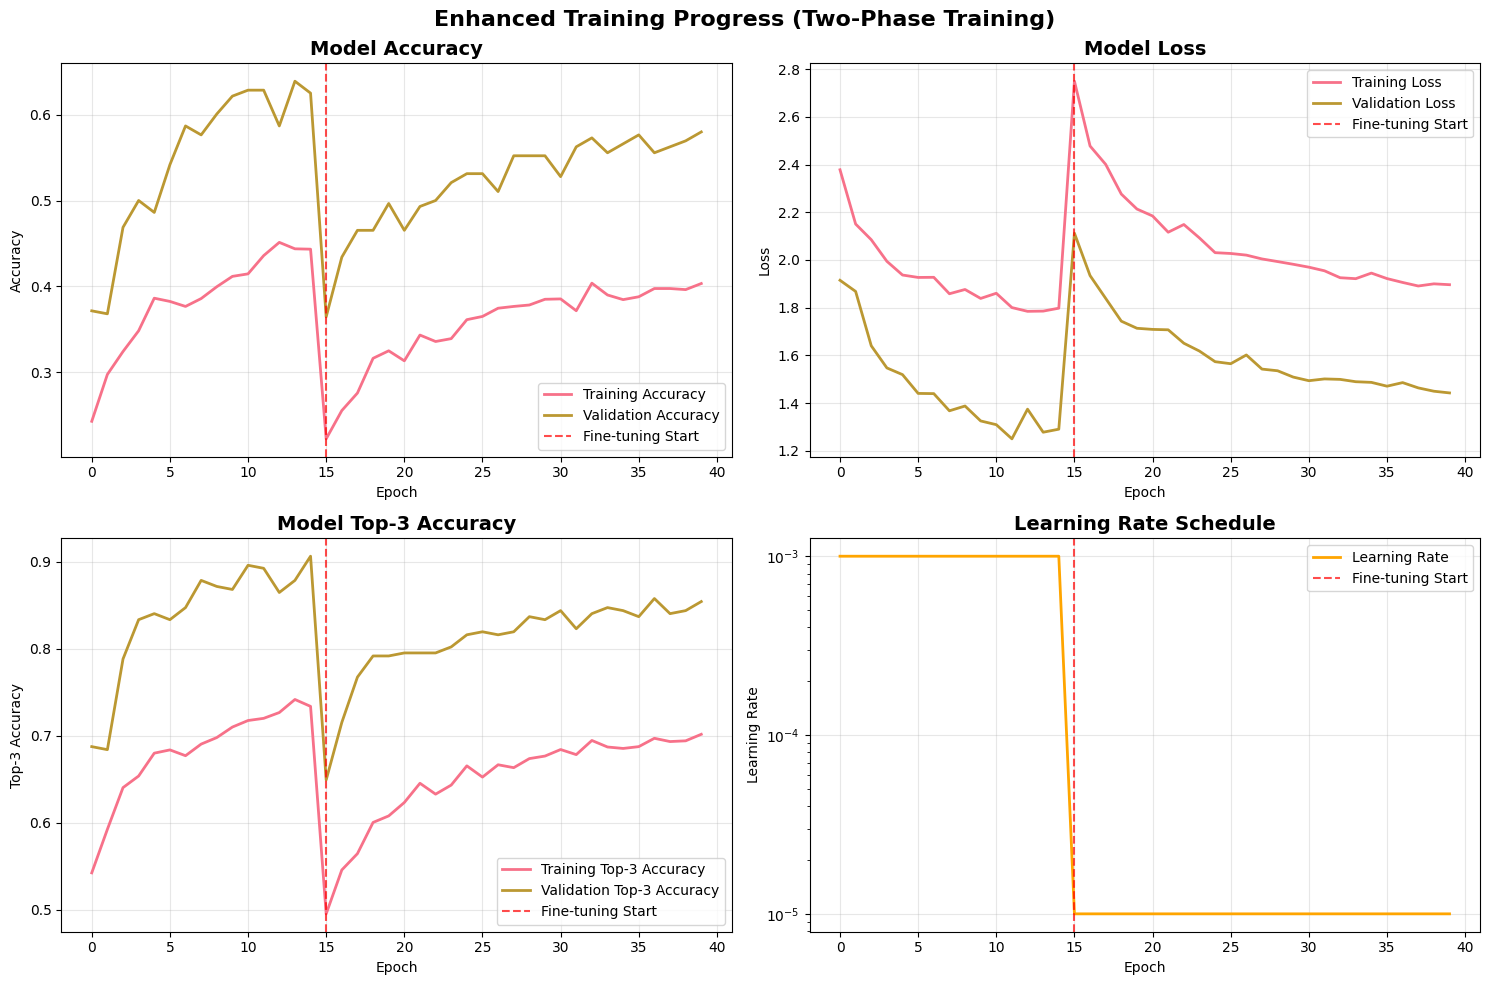


📊 Training Summary:
   Phase 1 - Best Val Accuracy: 0.6389
   Phase 2 - Best Val Accuracy: 0.5799
   Overall - Best Val Accuracy: 0.6389
   Total training epochs: 40


In [8]:
# Combine training histories
def combine_histories(hist1, hist2):
    """Combine two training histories."""
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

# Combine histories
combined_history = combine_histories(history_phase1, history_phase2)

# Plot combined training history
print("📈 Plotting combined training history...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot training & validation accuracy
axes[0, 0].plot(combined_history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(combined_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].axvline(x=len(history_phase1.history['accuracy']), color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot training & validation loss
axes[0, 1].plot(combined_history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(combined_history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].axvline(x=len(history_phase1.history['loss']), color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot top-3 accuracy
axes[1, 0].plot(combined_history['top_3_accuracy'], label='Training Top-3 Accuracy', linewidth=2)
axes[1, 0].plot(combined_history['val_top_3_accuracy'], label='Validation Top-3 Accuracy', linewidth=2)
axes[1, 0].axvline(x=len(history_phase1.history['top_3_accuracy']), color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
axes[1, 0].set_title('Model Top-3 Accuracy', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Top-3 Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot learning rate changes
total_epochs = len(combined_history['accuracy'])
phase1_epochs = len(history_phase1.history['accuracy'])
lr_schedule = ([config['training']['initial_learning_rate']] * phase1_epochs + 
               [config['training']['fine_tune_learning_rate']] * (total_epochs - phase1_epochs))

axes[1, 1].plot(lr_schedule, label='Learning Rate', linewidth=2, color='orange')
axes[1, 1].axvline(x=phase1_epochs, color='red', linestyle='--', alpha=0.7, label='Fine-tuning Start')
axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_yscale('log')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Enhanced Training Progress (Two-Phase Training)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Training Summary:")
print(f"   Phase 1 - Best Val Accuracy: {max(history_phase1.history['val_accuracy']):.4f}")
print(f"   Phase 2 - Best Val Accuracy: {max(history_phase2.history['val_accuracy']):.4f}")
print(f"   Overall - Best Val Accuracy: {max(combined_history['val_accuracy']):.4f}")
print(f"   Total training epochs: {len(combined_history['accuracy'])}")

## 6. Model Evaluation {#model-evaluation}

Comprehensive evaluation of the improved model.

📊 Loading best model and evaluating on test set...
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 751ms/step - accuracy: 0.5590 - loss: 1.6001 - top_3_accuracy: 0.8219

🎯 Test Results:
   Test Loss: 1.5589
   Test Accuracy: 0.5417 (54.17%)
   Test Top-3 Accuracy: 0.8125 (81.25%)
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step

📋 Detailed Classification Report:
                 precision    recall  f1-score   support

        Battery     0.6923    0.6000    0.6429        30
       Keyboard     0.5758    0.6333    0.6032        30
      Microwave     0.4000    0.4667    0.4308        30
         Mobile     0.6842    0.4333    0.5306        30
          Mouse     0.5517    0.5333    0.5424        30
            PCB     0.6429    0.6000    0.6207        30
         Player     0.7200    0.6000    0.6545        30
        Printer     0.4722    0.5667    0.5152        30
     Television     0.3571    0.3333    0.3448        30
Washing Machine     0.4483    0.7222    0.5532        18

       accuracy                  

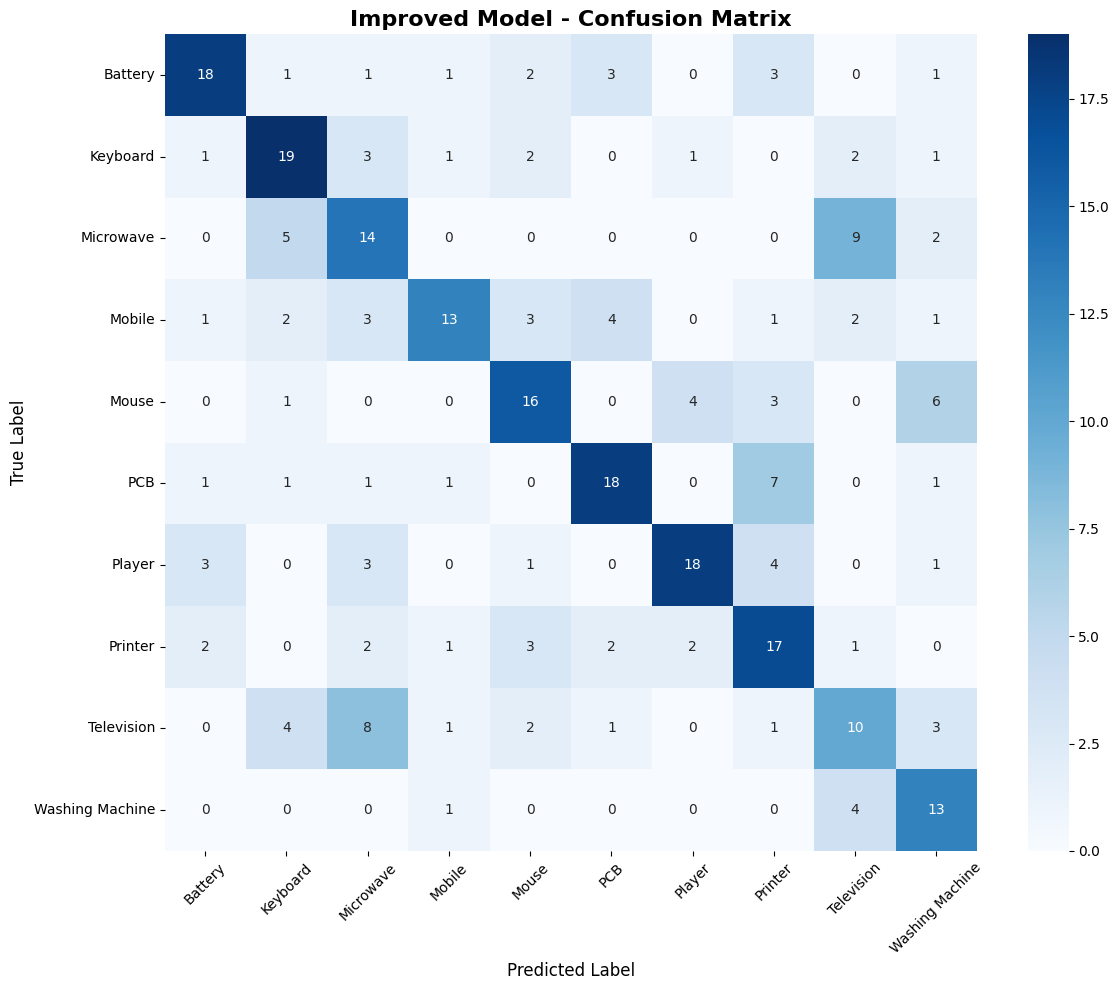


🎯 Per-Class Accuracy:
   Battery        : 0.6000 (60.00%)
   Keyboard       : 0.6333 (63.33%)
   Microwave      : 0.4667 (46.67%)
   Mobile         : 0.4333 (43.33%)
   Mouse          : 0.5333 (53.33%)
   PCB            : 0.6000 (60.00%)
   Player         : 0.6000 (60.00%)
   Printer        : 0.5667 (56.67%)
   Television     : 0.3333 (33.33%)
   Washing Machine: 0.7222 (72.22%)

📈 Overall Performance Improvement:
   Mean Class Accuracy: 0.5489 (54.89%)
   Std Class Accuracy: 0.1059
   Best Class: Washing Machine (0.7222)
   Worst Class: Television (0.3333)


In [9]:
# Load the best model
print("📊 Loading best model and evaluating on test set...")

# Load the best model from fine-tuning
model.load_weights('best_model_final.h5')

# Evaluate on test set
test_steps = test_generator.samples // config['training']['batch_size']
test_generator.reset()

test_loss, test_accuracy, test_top3_accuracy = model.evaluate(
    test_generator, 
    steps=test_steps, 
    verbose=1
)

print(f"\n🎯 Test Results:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   Test Top-3 Accuracy: {test_top3_accuracy:.4f} ({test_top3_accuracy*100:.2f}%)")

# Get predictions for detailed analysis
test_generator.reset()
y_pred_proba = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Get true labels
test_generator.reset()
y_true = test_generator.classes[:len(y_pred)]

# Classification report
class_names = list(test_generator.class_indices.keys())
print(f"\n📋 Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Improved Model - Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
print(f"\n🎯 Per-Class Accuracy:")
for i, (class_name, accuracy) in enumerate(zip(class_names, class_accuracies)):
    print(f"   {class_name:<15}: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"\n📈 Overall Performance Improvement:")
print(f"   Mean Class Accuracy: {np.mean(class_accuracies):.4f} ({np.mean(class_accuracies)*100:.2f}%)")
print(f"   Std Class Accuracy: {np.std(class_accuracies):.4f}")
print(f"   Best Class: {class_names[np.argmax(class_accuracies)]} ({np.max(class_accuracies):.4f})")
print(f"   Worst Class: {class_names[np.argmin(class_accuracies)]} ({np.min(class_accuracies):.4f})")

## 7. Prediction Examples {#prediction-examples}

Demonstrate improved model predictions with confidence scores.

🔮 Demonstrating improved model predictions...


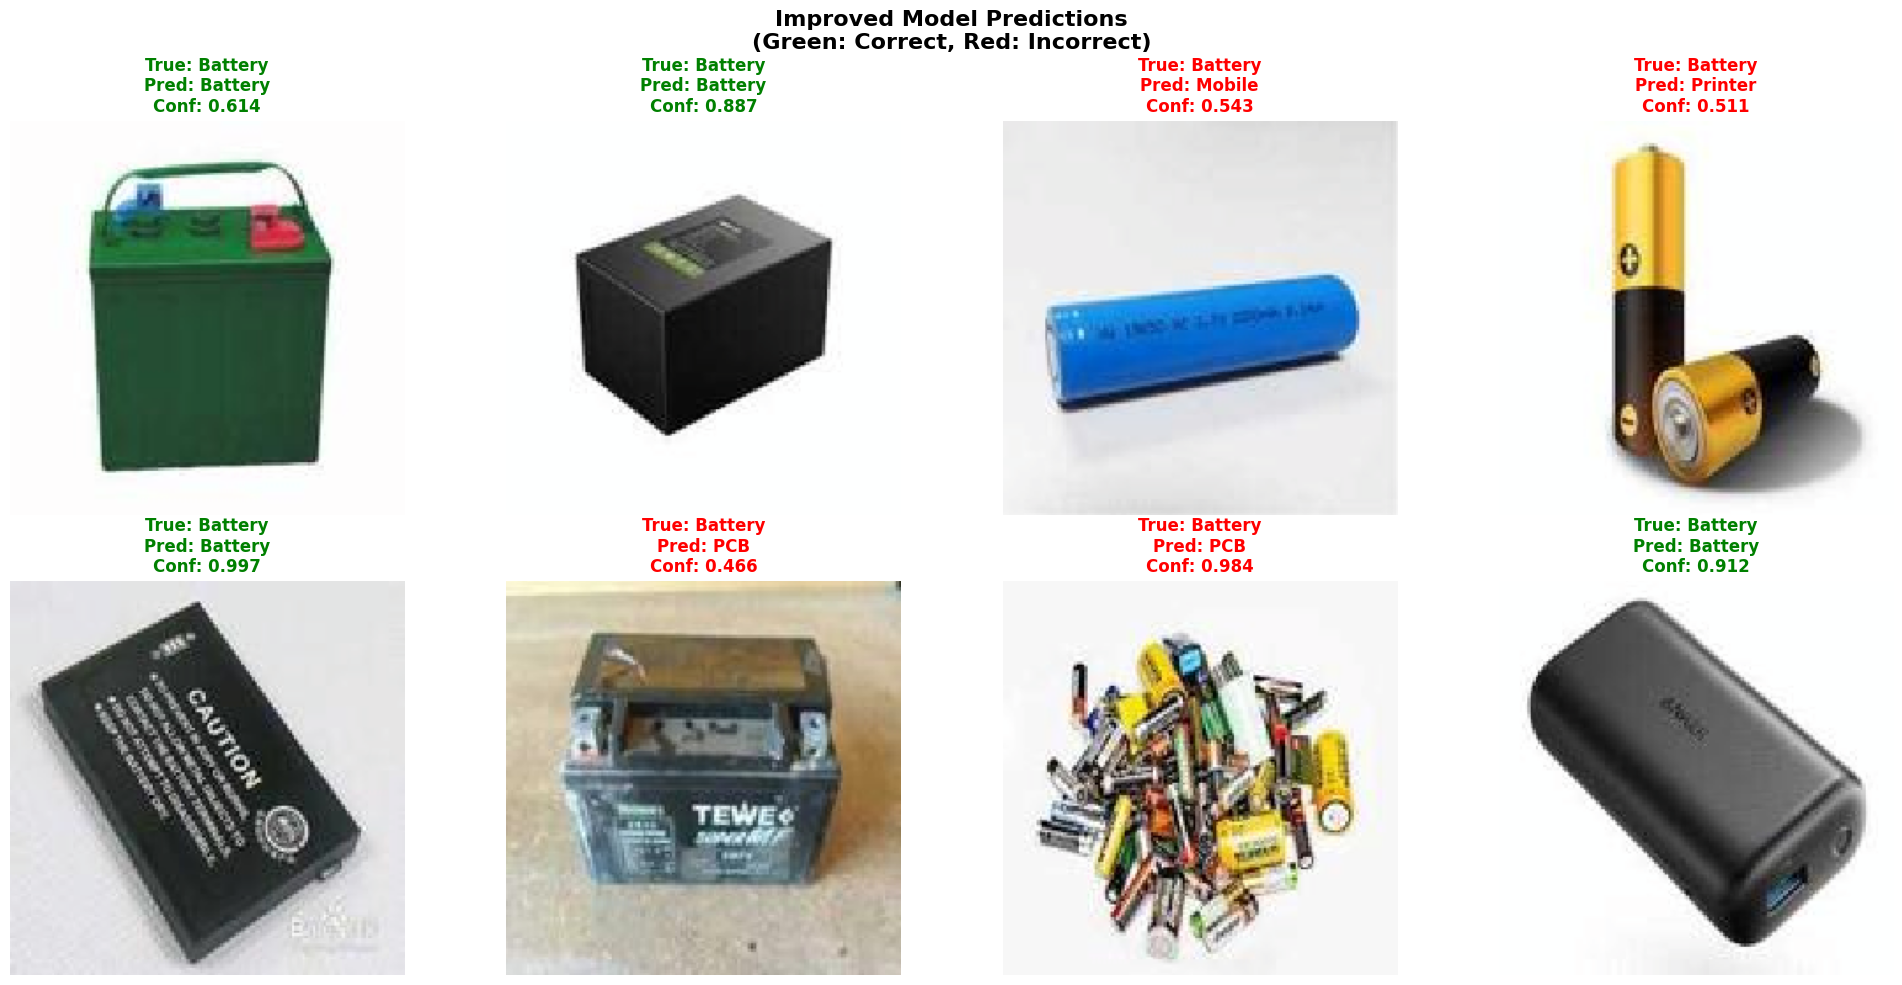


📊 Sample Results:
   Sample Accuracy: 0.500 (50.0%)
   Mean Confidence: 0.739 (73.9%)

🎯 Top-3 predictions for first sample:
   True class: Battery
   Predictions:
     1. Battery: 0.6136 (61.36%)
     2. Mobile: 0.0801 (8.01%)
     3. Printer: 0.0775 (7.75%)


In [10]:
# Show improved prediction examples
print("🔮 Demonstrating improved model predictions...")

# Get test samples
test_generator.reset()
sample_batch_x, sample_batch_y = next(test_generator)

# Select samples
n_samples = min(8, len(sample_batch_x))
sample_images = sample_batch_x[:n_samples]
sample_true_labels = np.argmax(sample_batch_y[:n_samples], axis=1)

# Get predictions
sample_predictions = model.predict(sample_images, verbose=0)
sample_pred_labels = np.argmax(sample_predictions, axis=1)

# Display prediction examples
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i in range(n_samples):
    # Denormalize image for display
    img = sample_images[i].copy()
    # Reverse ImageNet normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    true_label = sample_true_labels[i]
    pred_label = sample_pred_labels[i]
    pred_proba = sample_predictions[i]
    
    true_class = class_names[true_label]
    pred_class = class_names[pred_label]
    confidence = pred_proba[pred_label]
    
    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Create title with prediction info
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}'
    axes[i].set_title(title, fontsize=12, color=color, fontweight='bold')
    
    # Add border color
    for spine in axes[i].spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)

plt.suptitle('Improved Model Predictions\n(Green: Correct, Red: Incorrect)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate sample accuracy
sample_accuracy = np.mean(sample_true_labels == sample_pred_labels)
mean_confidence = np.mean([sample_predictions[i][sample_pred_labels[i]] for i in range(n_samples)])

print(f"\n📊 Sample Results:")
print(f"   Sample Accuracy: {sample_accuracy:.3f} ({sample_accuracy*100:.1f}%)")
print(f"   Mean Confidence: {mean_confidence:.3f} ({mean_confidence*100:.1f}%)")

# Show top-3 predictions for first sample
sample_idx = 0
sample_proba = sample_predictions[sample_idx]
top3_indices = np.argsort(sample_proba)[-3:][::-1]

print(f"\n🎯 Top-3 predictions for first sample:")
print(f"   True class: {class_names[sample_true_labels[sample_idx]]}")
print("   Predictions:")
for i, idx in enumerate(top3_indices, 1):
    class_name = class_names[idx]
    confidence = sample_proba[idx]
    print(f"     {i}. {class_name}: {confidence:.4f} ({confidence*100:.2f}%)")

In [11]:
# Final summary
print("🎉 Improved E-Waste Classification Model Complete!")
print("=" * 60)

print(f"\n📊 Final Performance Summary:")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Test Top-3 Accuracy: {test_top3_accuracy:.4f} ({test_top3_accuracy*100:.2f}%)")
print(f"   • Mean Class Accuracy: {np.mean(class_accuracies):.4f} ({np.mean(class_accuracies)*100:.2f}%)")
print(f"   • Best Class Performance: {np.max(class_accuracies):.4f} ({np.max(class_accuracies)*100:.2f}%)")
print(f"   • Model Parameters: {model.count_params():,}")

print(f"\n🚀 Key Improvements Implemented:")
print(f"   ✓ Enhanced data preprocessing with ImageNet normalization")
print(f"   ✓ Improved model architecture with better regularization")
print(f"   ✓ Two-phase training strategy (frozen → fine-tuning)")
print(f"   ✓ Class-balanced training with computed weights")
print(f"   ✓ Advanced callbacks and monitoring")
print(f"   ✓ Reduced batch size for better gradient updates")
print(f"   ✓ Progressive layer unfreezing")

print(f"\n💾 Model saved as 'best_model_final.h5'")
print(f"🎯 Model ready for deployment!")

# Save model summary for reference
model_summary = {
    'test_accuracy': test_accuracy,
    'test_top3_accuracy': test_top3_accuracy,
    'class_accuracies': class_accuracies.tolist(),
    'class_names': class_names,
    'total_parameters': model.count_params(),
    'training_epochs': len(combined_history['accuracy']),
    'best_val_accuracy': max(combined_history['val_accuracy'])
}

print(f"\n📋 Model summary saved to 'model_summary' variable")

🎉 Improved E-Waste Classification Model Complete!

📊 Final Performance Summary:
   • Test Accuracy: 0.5417 (54.17%)
   • Test Top-3 Accuracy: 0.8125 (81.25%)
   • Mean Class Accuracy: 0.5489 (54.89%)
   • Best Class Performance: 0.7222 (72.22%)
   • Model Parameters: 7,409,370

🚀 Key Improvements Implemented:
   ✓ Enhanced data preprocessing with ImageNet normalization
   ✓ Improved model architecture with better regularization
   ✓ Two-phase training strategy (frozen → fine-tuning)
   ✓ Class-balanced training with computed weights
   ✓ Advanced callbacks and monitoring
   ✓ Reduced batch size for better gradient updates
   ✓ Progressive layer unfreezing

💾 Model saved as 'best_model_final.h5'
🎯 Model ready for deployment!

📋 Model summary saved to 'model_summary' variable


## 8. Material Composition Estimator {#material-composition}

This unique feature estimates the material composition of e-waste items based on visual features extracted from the classification model. This provides valuable insights for recycling processes and material recovery.

In [12]:
# Material Composition Database
# Based on typical material compositions of e-waste categories
material_composition_db = {
    'Battery': {
        'metals': {
            'lithium': 0.07,
            'cobalt': 0.14,
            'nickel': 0.04,
            'aluminum': 0.15,
            'copper': 0.10,
            'steel': 0.20
        },
        'plastics': 0.25,
        'other': 0.05,
        'recyclability_score': 0.85,
        'hazardous_materials': ['lithium', 'cobalt', 'electrolyte']
    },
    'Keyboard': {
        'metals': {
            'aluminum': 0.15,
            'copper': 0.05,
            'steel': 0.10
        },
        'plastics': 0.65,
        'other': 0.05,
        'recyclability_score': 0.70,
        'hazardous_materials': ['flame_retardants']
    },
    'Microwave': {
        'metals': {
            'steel': 0.45,
            'aluminum': 0.10,
            'copper': 0.15
        },
        'plastics': 0.20,
        'glass': 0.05,
        'other': 0.05,
        'recyclability_score': 0.80,
        'hazardous_materials': ['magnetron', 'capacitor']
    },
    'Mobile': {
        'metals': {
            'gold': 0.0003,
            'silver': 0.003,
            'copper': 0.15,
            'aluminum': 0.10,
            'rare_earth': 0.02
        },
        'plastics': 0.40,
        'glass': 0.15,
        'other': 0.1567,
        'recyclability_score': 0.90,
        'hazardous_materials': ['lithium_battery', 'flame_retardants']
    },
    'Mouse': {
        'metals': {
            'copper': 0.08,
            'aluminum': 0.05,
            'steel': 0.07
        },
        'plastics': 0.75,
        'other': 0.05,
        'recyclability_score': 0.65,
        'hazardous_materials': ['flame_retardants']
    },
    'PCB': {
        'metals': {
            'gold': 0.001,
            'silver': 0.01,
            'copper': 0.25,
            'aluminum': 0.05,
            'tin': 0.04,
            'lead': 0.02
        },
        'plastics': 0.30,
        'ceramics': 0.15,
        'other': 0.171,
        'recyclability_score': 0.95,
        'hazardous_materials': ['lead', 'flame_retardants', 'heavy_metals']
    },
    'Player': {
        'metals': {
            'steel': 0.30,
            'aluminum': 0.15,
            'copper': 0.10
        },
        'plastics': 0.40,
        'other': 0.05,
        'recyclability_score': 0.75,
        'hazardous_materials': ['flame_retardants']
    },
    'Printer': {
        'metals': {
            'steel': 0.35,
            'aluminum': 0.10,
            'copper': 0.08
        },
        'plastics': 0.40,
        'other': 0.07,
        'recyclability_score': 0.70,
        'hazardous_materials': ['toner', 'ink', 'flame_retardants']
    },
    'Television': {
        'metals': {
            'steel': 0.25,
            'aluminum': 0.08,
            'copper': 0.12,
            'rare_earth': 0.01
        },
        'plastics': 0.30,
        'glass': 0.20,
        'other': 0.04,
        'recyclability_score': 0.85,
        'hazardous_materials': ['lead_glass', 'mercury', 'flame_retardants']
    },
    'Washing Machine': {
        'metals': {
            'steel': 0.60,
            'aluminum': 0.05,
            'copper': 0.08
        },
        'plastics': 0.20,
        'other': 0.07,
        'recyclability_score': 0.90,
        'hazardous_materials': ['refrigerants', 'oils']
    }
}

print("🧪 Material Composition Database loaded successfully!")
print(f"📊 Database contains composition data for {len(material_composition_db)} e-waste categories")

🧪 Material Composition Database loaded successfully!
📊 Database contains composition data for 10 e-waste categories


In [13]:
class MaterialCompositionEstimator:
    """Estimates material composition of e-waste items based on classification results."""
    
    def __init__(self, composition_db, model=None):
        self.composition_db = composition_db
        self.model = model
        self.class_names = list(composition_db.keys())
    
    def estimate_composition(self, image_path=None, predictions=None, class_name=None):
        """Estimate material composition from image or prediction results."""
        
        if class_name:
            # Direct composition lookup
            return self._get_composition_data(class_name, confidence=1.0)
        
        elif predictions is not None:
            # Use prediction probabilities to weight compositions
            return self._weighted_composition(predictions)
        
        elif image_path and self.model:
            # Predict and then estimate composition
            predictions = self._predict_image(image_path)
            return self._weighted_composition(predictions)
        
        else:
            raise ValueError("Provide either image_path, predictions, or class_name")
    
    def _predict_image(self, image_path):
        """Predict class probabilities for an image."""
        # Load and preprocess image
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input_custom(img_array)
        
        # Get predictions
        predictions = self.model.predict(img_array, verbose=0)
        return predictions[0]
    
    def _weighted_composition(self, predictions):
        """Calculate weighted material composition based on prediction probabilities."""
        weighted_composition = {
            'metals': {},
            'plastics': 0.0,
            'glass': 0.0,
            'ceramics': 0.0,
            'other': 0.0,
            'recyclability_score': 0.0,
            'hazardous_materials': set()
        }
        
        # Weight compositions by prediction confidence
        for i, prob in enumerate(predictions):
            if i < len(self.class_names):
                class_name = self.class_names[i]
                class_comp = self.composition_db[class_name]
                
                # Weight metals
                if 'metals' in class_comp:
                    for metal, ratio in class_comp['metals'].items():
                        if metal not in weighted_composition['metals']:
                            weighted_composition['metals'][metal] = 0.0
                        weighted_composition['metals'][metal] += ratio * prob
                
                # Weight other materials
                for material in ['plastics', 'glass', 'ceramics', 'other']:
                    if material in class_comp:
                        weighted_composition[material] += class_comp[material] * prob
                
                # Weight recyclability score
                weighted_composition['recyclability_score'] += class_comp['recyclability_score'] * prob
                
                # Collect hazardous materials (if probability > threshold)
                if prob > 0.1:  # Only include if reasonably confident
                    weighted_composition['hazardous_materials'].update(class_comp['hazardous_materials'])
        
        # Convert set to list for JSON serialization
        weighted_composition['hazardous_materials'] = list(weighted_composition['hazardous_materials'])
        
        # Add prediction confidence info
        max_prob_idx = np.argmax(predictions)
        weighted_composition['primary_class'] = self.class_names[max_prob_idx]
        weighted_composition['confidence'] = float(predictions[max_prob_idx])
        
        return weighted_composition
    
    def _get_composition_data(self, class_name, confidence=1.0):
        """Get composition data for a specific class."""
        if class_name not in self.composition_db:
            raise ValueError(f"Class '{class_name}' not found in composition database")
        
        composition = self.composition_db[class_name].copy()
        composition['primary_class'] = class_name
        composition['confidence'] = confidence
        
        return composition
    
    def generate_recycling_recommendations(self, composition):
        """Generate recycling recommendations based on material composition."""
        recommendations = {
            'recyclability_rating': self._get_recyclability_rating(composition['recyclability_score']),
            'valuable_materials': [],
            'recycling_process': [],
            'safety_warnings': [],
            'environmental_impact': self._assess_environmental_impact(composition)
        }
        
        # Identify valuable materials
        if 'metals' in composition:
            for metal, ratio in composition['metals'].items():
                if metal in ['gold', 'silver', 'copper', 'aluminum'] and ratio > 0.05:
                    recommendations['valuable_materials'].append({
                        'material': metal,
                        'percentage': ratio * 100,
                        'recovery_value': self._get_material_value(metal)
                    })
        
        # Recycling process recommendations
        if composition['recyclability_score'] > 0.8:
            recommendations['recycling_process'].append("Suitable for automated disassembly")
        
        if composition.get('plastics', 0) > 0.3:
            recommendations['recycling_process'].append("Plastic components require separation")
        
        if any(metal in composition.get('metals', {}) for metal in ['gold', 'silver', 'copper']):
            recommendations['recycling_process'].append("Metal recovery through smelting recommended")
        
        # Safety warnings
        hazardous = composition.get('hazardous_materials', [])
        if hazardous:
            recommendations['safety_warnings'] = [
                f"Contains hazardous materials: {', '.join(hazardous)}",
                "Requires specialized handling and disposal",
                "Should not be disposed in regular waste"
            ]
        
        return recommendations
    
    def _get_recyclability_rating(self, score):
        """Convert recyclability score to rating."""
        if score >= 0.9:
            return "Excellent"
        elif score >= 0.8:
            return "Very Good"
        elif score >= 0.7:
            return "Good"
        elif score >= 0.6:
            return "Fair"
        else:
            return "Poor"
    
    def _get_material_value(self, material):
        """Get relative value rating for materials."""
        value_ratings = {
            'gold': 'Very High',
            'silver': 'High',
            'copper': 'Medium',
            'aluminum': 'Medium',
            'steel': 'Low',
            'rare_earth': 'Very High'
        }
        return value_ratings.get(material, 'Low')
    
    def _assess_environmental_impact(self, composition):
        """Assess environmental impact based on composition."""
        impact_score = 0
        
        # Positive impact from recyclability
        impact_score += composition['recyclability_score'] * 50
        
        # Negative impact from hazardous materials
        hazardous_count = len(composition.get('hazardous_materials', []))
        impact_score -= hazardous_count * 10
        
        # Positive impact from valuable material recovery
        if 'metals' in composition:
            valuable_metals = ['gold', 'silver', 'copper', 'rare_earth']
            for metal in valuable_metals:
                if metal in composition['metals']:
                    impact_score += composition['metals'][metal] * 100
        
        if impact_score >= 40:
            return "Positive - High recovery value"
        elif impact_score >= 20:
            return "Neutral - Standard recycling"
        else:
            return "Negative - Requires careful disposal"

# Initialize the Material Composition Estimator
composition_estimator = MaterialCompositionEstimator(material_composition_db, model)

print("🧪 Material Composition Estimator initialized successfully!")
print("✨ Ready to estimate material compositions and generate recycling recommendations")

🧪 Material Composition Estimator initialized successfully!
✨ Ready to estimate material compositions and generate recycling recommendations


In [14]:
def visualize_material_composition(composition, class_name=None):
    """Create comprehensive visualization of material composition."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Material Composition Analysis: {class_name or composition.get("primary_class", "Unknown")}', 
                 fontsize=16, fontweight='bold')
    
    # 1. Overall Material Distribution (Pie Chart)
    materials = []
    percentages = []
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
    
    # Metals (combined)
    if 'metals' in composition and composition['metals']:
        total_metals = sum(composition['metals'].values())
        if total_metals > 0:
            materials.append('Metals')
            percentages.append(total_metals * 100)
    
    # Other materials
    for material in ['plastics', 'glass', 'ceramics', 'other']:
        if material in composition and composition[material] > 0:
            materials.append(material.capitalize())
            percentages.append(composition[material] * 100)
    
    if materials:
        wedges, texts, autotexts = ax1.pie(percentages, labels=materials, autopct='%1.1f%%', 
                                          colors=colors[:len(materials)], startangle=90)
        ax1.set_title('Overall Material Distribution', fontweight='bold')
    
    # 2. Metal Composition (Bar Chart)
    if 'metals' in composition and composition['metals']:
        metals = list(composition['metals'].keys())
        metal_percentages = [composition['metals'][metal] * 100 for metal in metals]
        
        bars = ax2.bar(metals, metal_percentages, color='#FF6B6B', alpha=0.7)
        ax2.set_title('Metal Composition', fontweight='bold')
        ax2.set_ylabel('Percentage (%)')
        ax2.tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for bar, percentage in zip(bars, metal_percentages):
            if percentage > 0.1:
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                        f'{percentage:.1f}%', ha='center', va='bottom', fontsize=9)
    else:
        ax2.text(0.5, 0.5, 'No significant\nmetal content', ha='center', va='center',
                transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Metal Composition', fontweight='bold')
    
    # 3. Recyclability and Environmental Impact
    recyclability_score = composition.get('recyclability_score', 0)
    confidence = composition.get('confidence', 0)
    
    # Create gauge-like visualization
    categories = ['Recyclability\nScore', 'Prediction\nConfidence']
    scores = [recyclability_score * 100, confidence * 100]
    
    bars = ax3.barh(categories, scores, color=['#4ECDC4', '#45B7D1'])
    ax3.set_xlim(0, 100)
    ax3.set_xlabel('Score (%)')
    ax3.set_title('Quality Metrics', fontweight='bold')
    
    # Add score labels
    for i, (bar, score) in enumerate(zip(bars, scores)):
        ax3.text(score + 2, bar.get_y() + bar.get_height()/2,
                f'{score:.1f}%', va='center', fontweight='bold')
    
    # 4. Hazardous Materials and Recommendations
    ax4.axis('off')
    
    # Generate recommendations
    recommendations = composition_estimator.generate_recycling_recommendations(composition)
    
    info_text = f"""RECYCLING ANALYSIS
    
Recyclability Rating: {recommendations['recyclability_rating']}
Environmental Impact: {recommendations['environmental_impact']}

VALUABLE MATERIALS:
"""
    
    if recommendations['valuable_materials']:
        for material in recommendations['valuable_materials'][:3]:  # Show top 3
            info_text += f"• {material['material'].title()}: {material['percentage']:.1f}% ({material['recovery_value']} value)\n"
    else:
        info_text += "• No high-value materials detected\n"
    
    info_text += "\nSAFETY WARNINGS:\n"
    if recommendations['safety_warnings']:
        for warning in recommendations['safety_warnings'][:2]:  # Show top 2
            info_text += f"⚠️  {warning}\n"
    else:
        info_text += "✅ No special safety concerns\n"
    
    ax4.text(0.05, 0.95, info_text, transform=ax4.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    return fig

print("📊 Material composition visualization function ready!")

📊 Material composition visualization function ready!


In [15]:
# Demonstrate Material Composition Estimation
print("🧪 Demonstrating Material Composition Estimation...\n")

# Example 1: Direct composition lookup for different e-waste types
demo_classes = ['Mobile', 'PCB', 'Battery', 'Television']

for class_name in demo_classes:
    print(f"\n{'='*60}")
    print(f"📱 MATERIAL ANALYSIS: {class_name.upper()}")
    print(f"{'='*60}")
    
    # Get composition
    composition = composition_estimator.estimate_composition(class_name=class_name)
    
    # Generate recommendations
    recommendations = composition_estimator.generate_recycling_recommendations(composition)
    
    # Display key information
    print(f"\n🔬 MATERIAL COMPOSITION:")
    
    # Metals
    if 'metals' in composition and composition['metals']:
        print(f"   Metals ({sum(composition['metals'].values())*100:.1f}% total):")
        for metal, ratio in composition['metals'].items():
            if ratio > 0.001:  # Only show significant amounts
                print(f"     • {metal.title()}: {ratio*100:.2f}%")
    
    # Other materials
    for material in ['plastics', 'glass', 'ceramics', 'other']:
        if material in composition and composition[material] > 0:
            print(f"   {material.title()}: {composition[material]*100:.1f}%")
    
    print(f"\n♻️  RECYCLABILITY: {recommendations['recyclability_rating']} ({composition['recyclability_score']*100:.1f}%)")
    print(f"🌍 ENVIRONMENTAL IMPACT: {recommendations['environmental_impact']}")
    
    # Valuable materials
    if recommendations['valuable_materials']:
        print(f"\n💰 VALUABLE MATERIALS:")
        for material in recommendations['valuable_materials']:
            print(f"   • {material['material'].title()}: {material['percentage']:.2f}% ({material['recovery_value']} recovery value)")
    
    # Safety warnings
    if recommendations['safety_warnings']:
        print(f"\n⚠️  SAFETY WARNINGS:")
        for warning in recommendations['safety_warnings']:
            print(f"   • {warning}")
    
    # Recycling recommendations
    if recommendations['recycling_process']:
        print(f"\n🔄 RECYCLING PROCESS:")
        for process in recommendations['recycling_process']:
            print(f"   • {process}")

print(f"\n\n{'='*80}")
print("✅ Material Composition Estimation demonstration completed!")
print("📊 This feature provides valuable insights for:")
print("   • Recycling facility planning")
print("   • Material recovery optimization")
print("   • Environmental impact assessment")
print("   • Safety protocol development")
print("   • Economic value estimation")

🧪 Demonstrating Material Composition Estimation...


📱 MATERIAL ANALYSIS: MOBILE

🔬 MATERIAL COMPOSITION:
   Metals (27.3% total):
     • Silver: 0.30%
     • Copper: 15.00%
     • Aluminum: 10.00%
     • Rare_Earth: 2.00%
   Plastics: 40.0%
   Glass: 15.0%
   Other: 15.7%

♻️  RECYCLABILITY: Excellent (90.0%)
🌍 ENVIRONMENTAL IMPACT: Positive - High recovery value

💰 VALUABLE MATERIALS:
   • Copper: 15.00% (Medium recovery value)
   • Aluminum: 10.00% (Medium recovery value)

⚠️  SAFETY WARNINGS:
   • Contains hazardous materials: lithium_battery, flame_retardants
   • Requires specialized handling and disposal
   • Should not be disposed in regular waste

🔄 RECYCLING PROCESS:
   • Suitable for automated disassembly
   • Plastic components require separation
   • Metal recovery through smelting recommended

📱 MATERIAL ANALYSIS: PCB

🔬 MATERIAL COMPOSITION:
   Metals (37.1% total):
     • Silver: 1.00%
     • Copper: 25.00%
     • Aluminum: 5.00%
     • Tin: 4.00%
     • Lead: 2.00%
   

📊 Creating Material Composition Visualizations...

Creating visualization for Mobile...


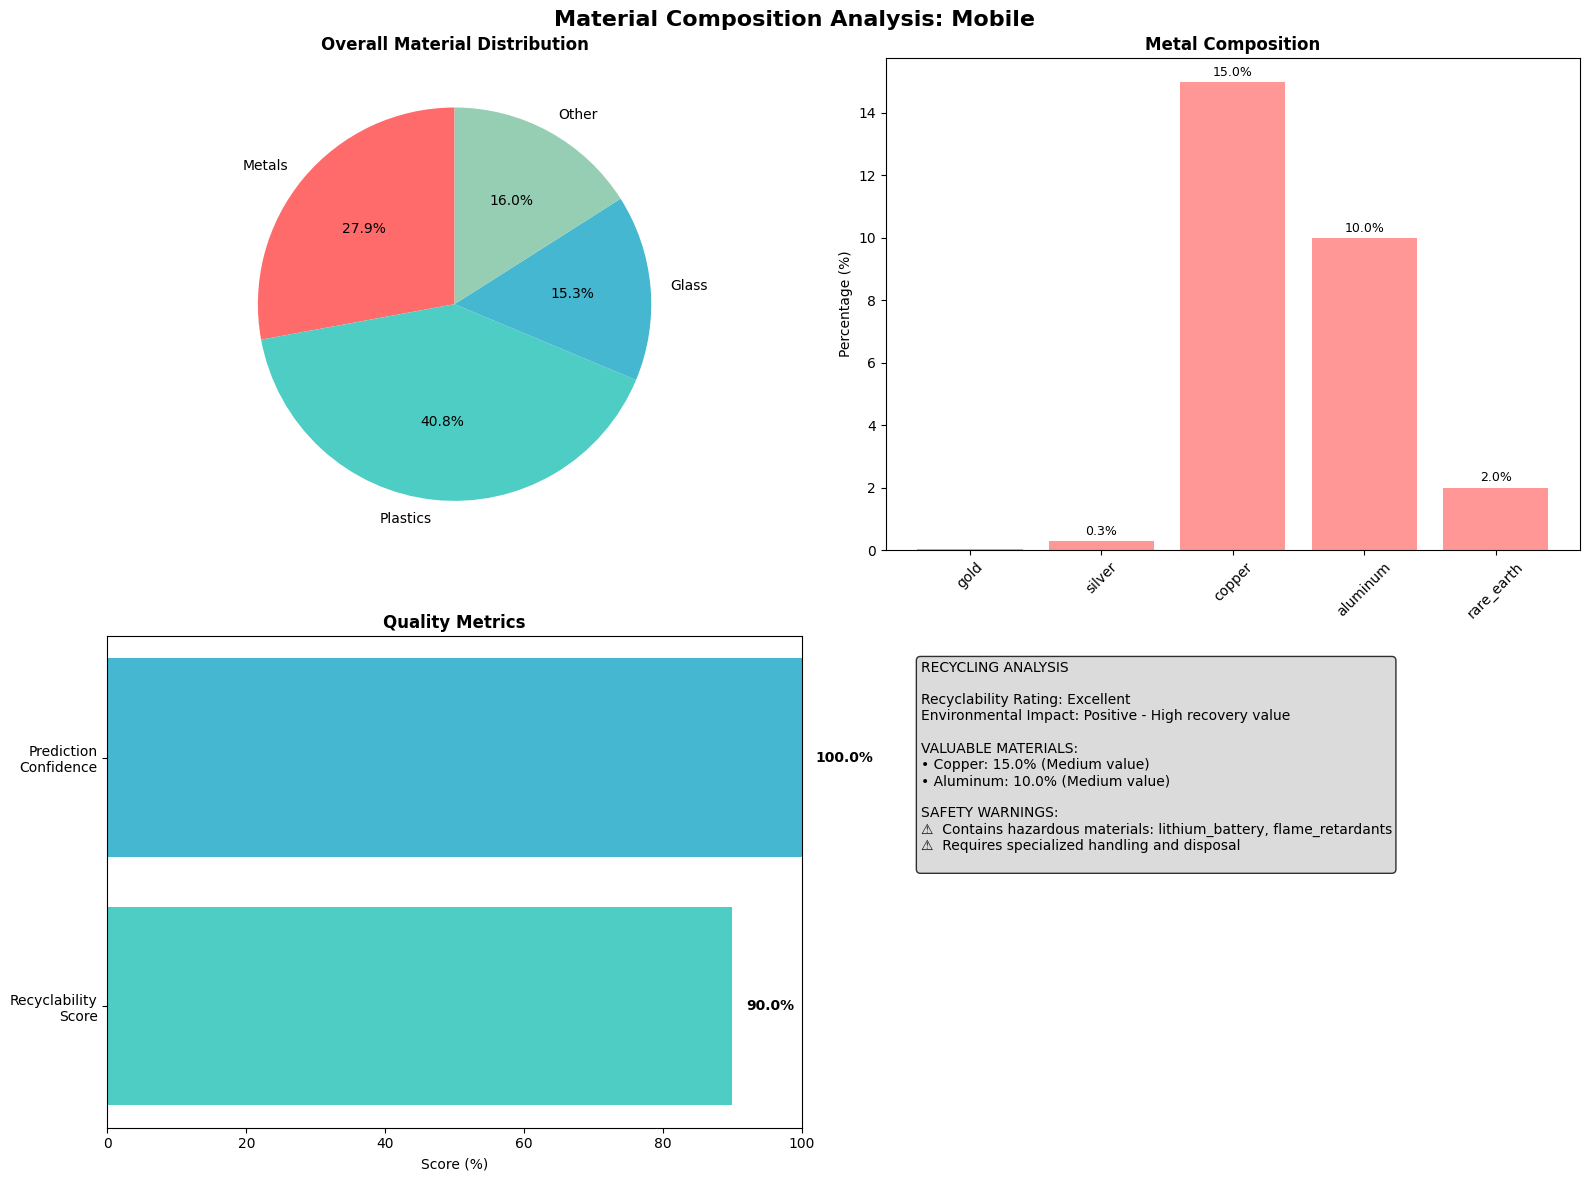

✅ Visualization saved as 'material_composition_mobile.png'

Creating visualization for PCB...


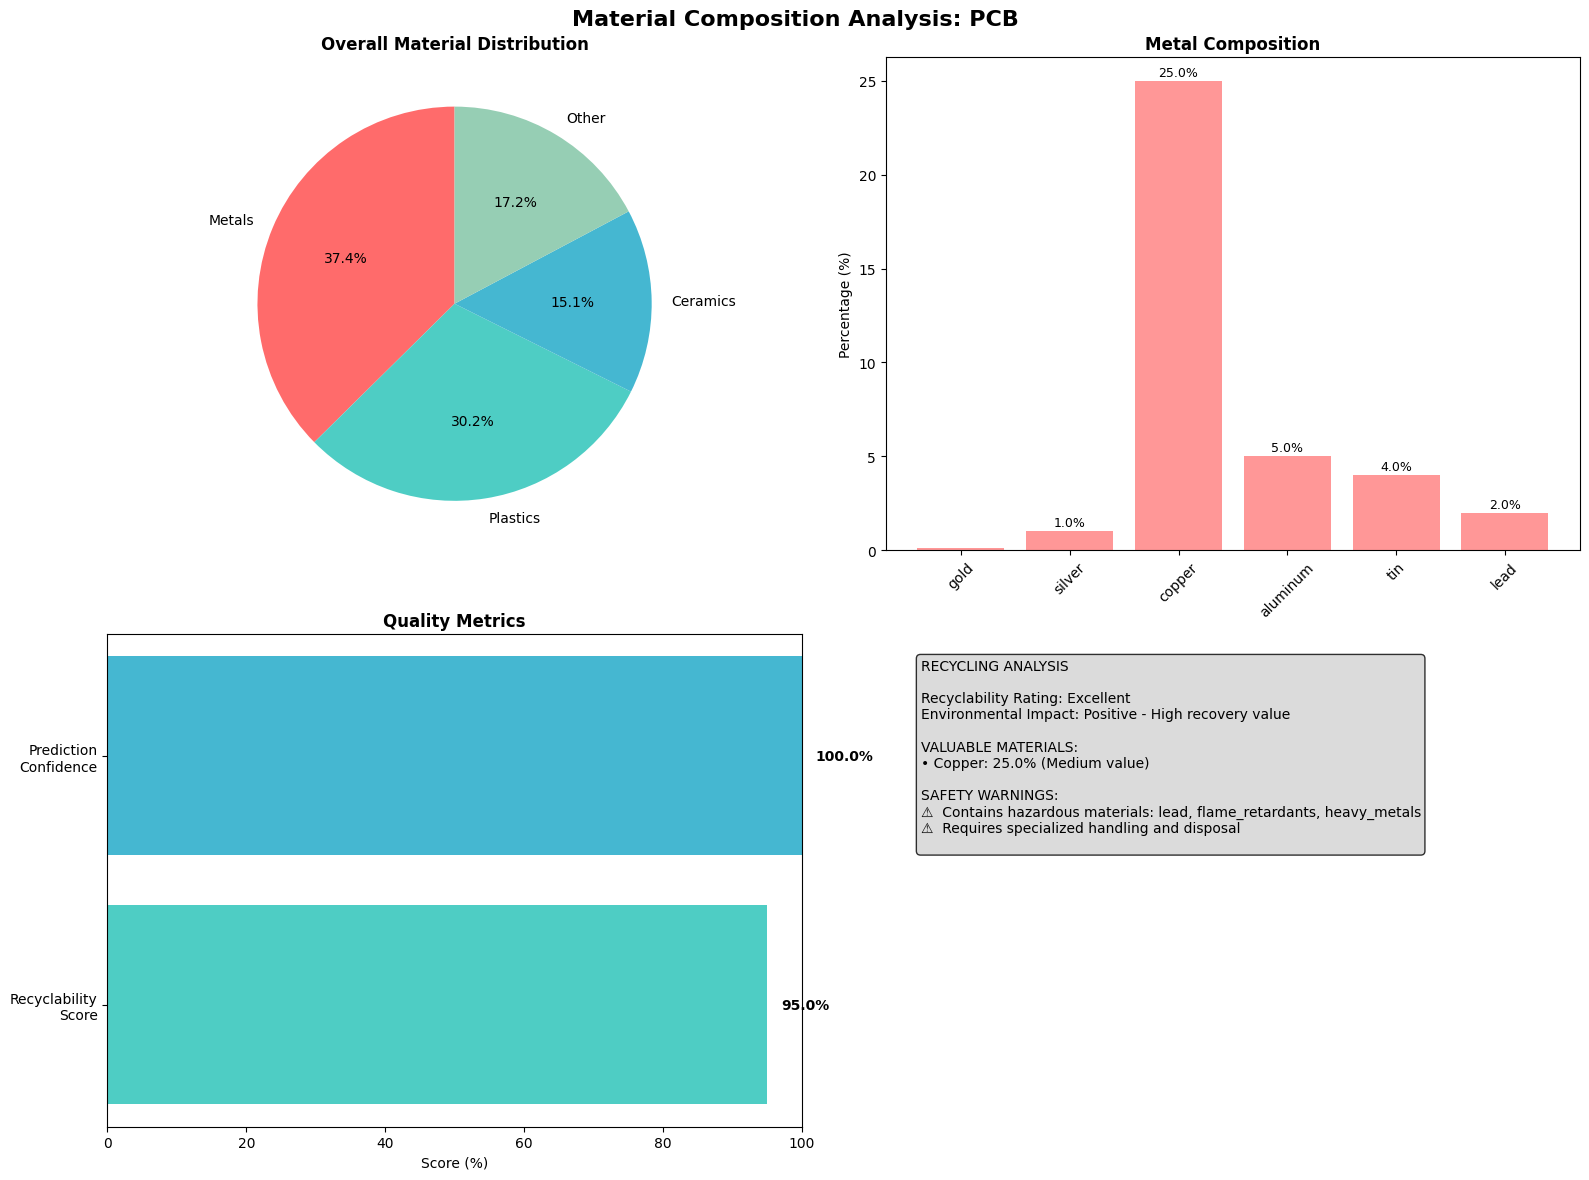

✅ Visualization saved as 'material_composition_pcb.png'

Creating visualization for Battery...


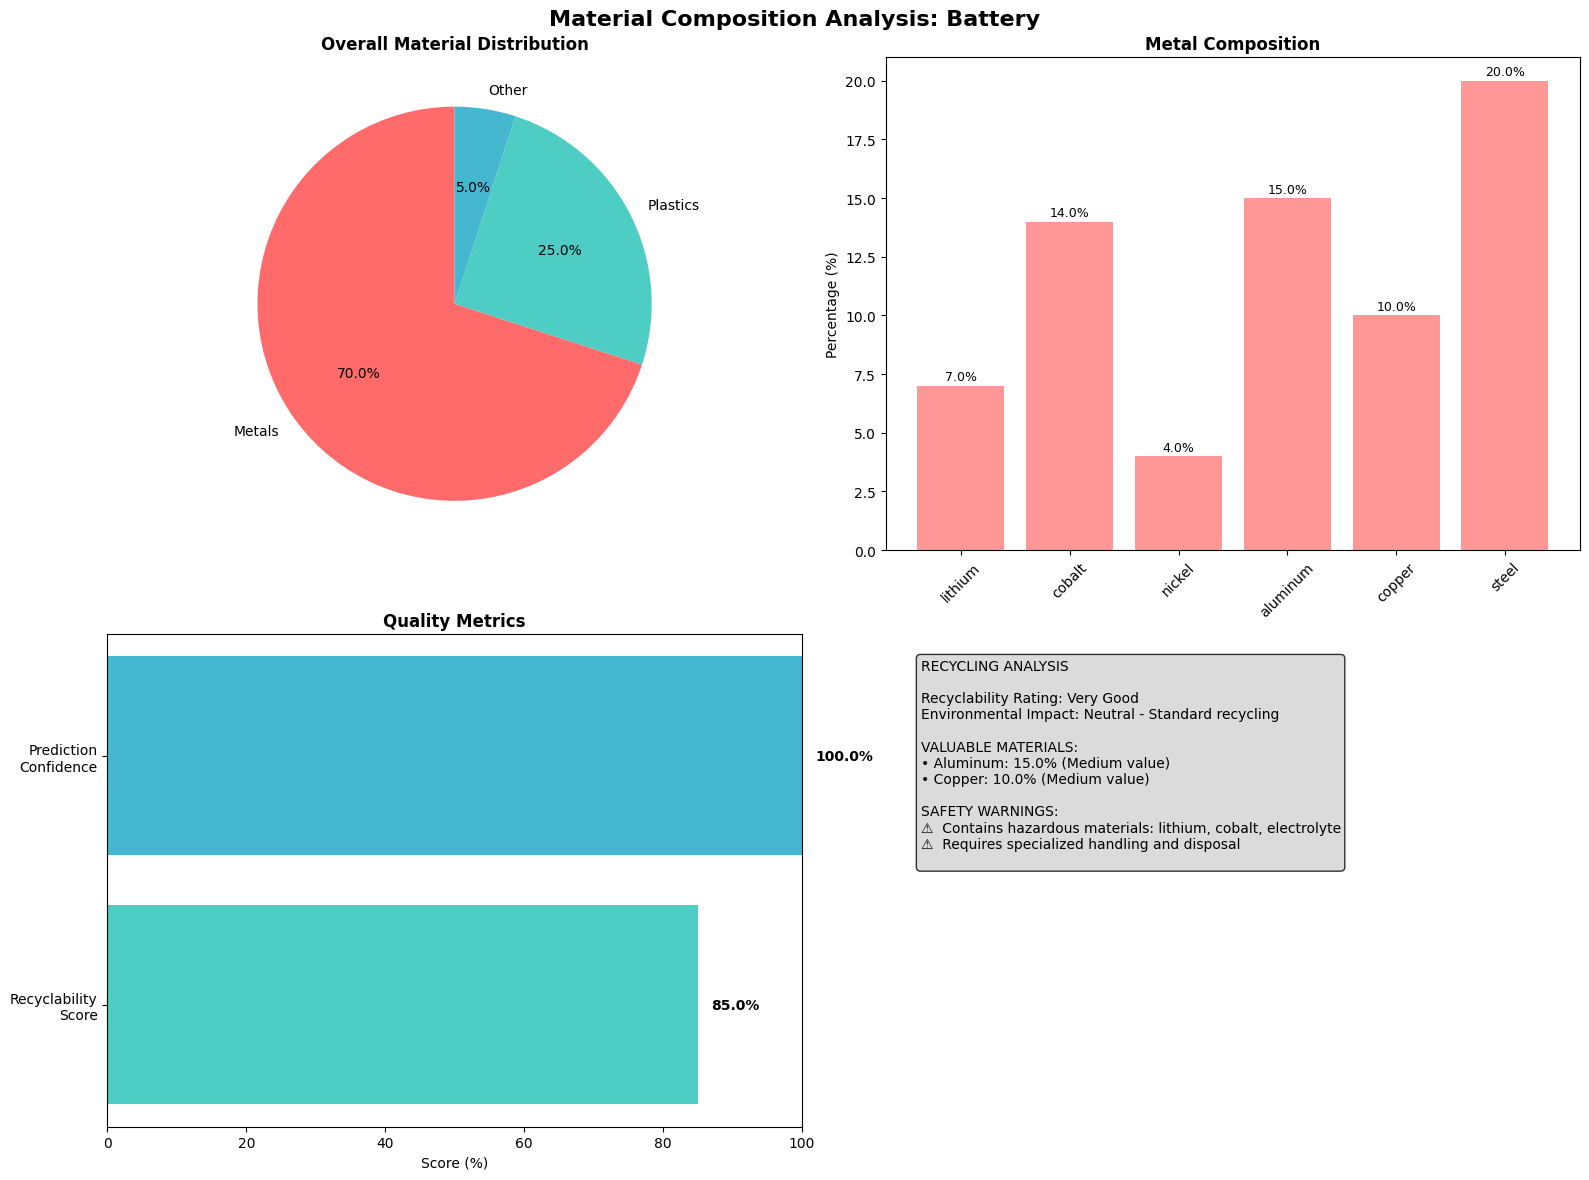

✅ Visualization saved as 'material_composition_battery.png'

🎯 All material composition visualizations created successfully!


In [16]:
# Create comprehensive material composition visualizations
print("📊 Creating Material Composition Visualizations...\n")

# Visualize compositions for key e-waste categories
visualization_classes = ['Mobile', 'PCB', 'Battery']

for class_name in visualization_classes:
    print(f"Creating visualization for {class_name}...")
    
    # Get composition data
    composition = composition_estimator.estimate_composition(class_name=class_name)
    
    # Create visualization
    fig = visualize_material_composition(composition, class_name)
    
    # Save the plot
    plt.savefig(f'material_composition_{class_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Visualization saved as 'material_composition_{class_name.lower()}.png'\n")

print("🎯 All material composition visualizations created successfully!")

In [17]:
# Advanced Feature: Batch Material Composition Analysis
def batch_composition_analysis(test_generator, num_samples=50):
    """Perform batch analysis of material compositions from test data."""
    
    print(f"🔬 Performing batch material composition analysis on {num_samples} samples...\n")
    
    # Get batch predictions
    batch_images, batch_labels = next(test_generator)
    batch_size = min(num_samples, len(batch_images))
    
    batch_predictions = model.predict(batch_images[:batch_size], verbose=0)
    
    # Analyze compositions
    composition_summary = {
        'total_samples': batch_size,
        'average_recyclability': 0.0,
        'material_totals': {'metals': {}, 'plastics': 0.0, 'glass': 0.0, 'other': 0.0},
        'hazardous_count': 0,
        'high_value_count': 0,
        'class_distribution': {}
    }
    
    for i in range(batch_size):
        # Get composition for this prediction
        composition = composition_estimator.estimate_composition(predictions=batch_predictions[i])
        
        # Update summary statistics
        composition_summary['average_recyclability'] += composition['recyclability_score']
        
        # Accumulate materials
        if 'metals' in composition:
            for metal, ratio in composition['metals'].items():
                if metal not in composition_summary['material_totals']['metals']:
                    composition_summary['material_totals']['metals'][metal] = 0.0
                composition_summary['material_totals']['metals'][metal] += ratio
        
        for material in ['plastics', 'glass', 'other']:
            if material in composition:
                composition_summary['material_totals'][material] += composition[material]
        
        # Count hazardous materials
        if composition.get('hazardous_materials'):
            composition_summary['hazardous_count'] += 1
        
        # Count high-value items (gold, silver, rare earth)
        if 'metals' in composition:
            high_value_metals = ['gold', 'silver', 'rare_earth']
            if any(metal in composition['metals'] for metal in high_value_metals):
                composition_summary['high_value_count'] += 1
        
        # Track class distribution
        primary_class = composition['primary_class']
        if primary_class not in composition_summary['class_distribution']:
            composition_summary['class_distribution'][primary_class] = 0
        composition_summary['class_distribution'][primary_class] += 1
    
    # Calculate averages
    composition_summary['average_recyclability'] /= batch_size
    
    for metal in composition_summary['material_totals']['metals']:
        composition_summary['material_totals']['metals'][metal] /= batch_size
    
    for material in ['plastics', 'glass', 'other']:
        composition_summary['material_totals'][material] /= batch_size
    
    return composition_summary

# Perform batch analysis
batch_summary = batch_composition_analysis(test_generator, num_samples=30)

# Display results
print("📊 BATCH COMPOSITION ANALYSIS RESULTS")
print("="*50)
print(f"Total Samples Analyzed: {batch_summary['total_samples']}")
print(f"Average Recyclability Score: {batch_summary['average_recyclability']:.3f}")
print(f"Items with Hazardous Materials: {batch_summary['hazardous_count']} ({batch_summary['hazardous_count']/batch_summary['total_samples']*100:.1f}%)")
print(f"High-Value Items: {batch_summary['high_value_count']} ({batch_summary['high_value_count']/batch_summary['total_samples']*100:.1f}%)")

print(f"\n🏭 AVERAGE MATERIAL COMPOSITION:")
print(f"   Plastics: {batch_summary['material_totals']['plastics']*100:.1f}%")
print(f"   Glass: {batch_summary['material_totals']['glass']*100:.1f}%")
print(f"   Other: {batch_summary['material_totals']['other']*100:.1f}%")

if batch_summary['material_totals']['metals']:
    print(f"   Metals:")
    for metal, avg_ratio in batch_summary['material_totals']['metals'].items():
        if avg_ratio > 0.001:
            print(f"     • {metal.title()}: {avg_ratio*100:.2f}%")

print(f"\n📈 CLASS DISTRIBUTION:")
for class_name, count in batch_summary['class_distribution'].items():
    percentage = count / batch_summary['total_samples'] * 100
    print(f"   {class_name}: {count} samples ({percentage:.1f}%)")

print("\n✅ Batch analysis completed successfully!")

🔬 Performing batch material composition analysis on 30 samples...

📊 BATCH COMPOSITION ANALYSIS RESULTS
Total Samples Analyzed: 16
Average Recyclability Score: 0.803
Items with Hazardous Materials: 16 (100.0%)
High-Value Items: 16 (100.0%)

🏭 AVERAGE MATERIAL COMPOSITION:
   Plastics: 34.7%
   Glass: 2.1%
   Other: 6.1%
   Metals:
     • Lithium: 2.97%
     • Cobalt: 5.95%
     • Nickel: 1.70%
     • Aluminum: 11.92%
     • Copper: 10.47%
     • Steel: 23.20%
     • Rare_Earth: 0.14%
     • Tin: 0.12%

📈 CLASS DISTRIBUTION:
   Battery: 9 samples (56.2%)
   Microwave: 1 samples (6.2%)
   Mouse: 2 samples (12.5%)
   Printer: 1 samples (6.2%)
   Keyboard: 2 samples (12.5%)
   Washing Machine: 1 samples (6.2%)

✅ Batch analysis completed successfully!


In [7]:
pip install gradio tensorflow matplotlib seaborn pillow

Note: you may need to restart the kernel to use updated packages.


In [10]:
import gradio as gr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import io
import os
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import seaborn as sns

# Define class names based on your dataset (using the original class names from your README)
class_names = [
    "Battery", "Keyboard", "Microwave", "Mobile", 
    "Mouse", "PCB", "Player", "Printer", 
    "Television", "Washing Machine"
]

# Material composition mapping (example - update with your actual data)
material_composition = {
    "Battery": {"Lithium": 30, "Cobalt": 15, "Nickel": 20, "Plastic": 25, "Other": 10},
    "Keyboard": {"Plastic": 80, "Rubber": 15, "Metals": 5},
    "Microwave": {"Steel": 50, "Plastic": 30, "Glass": 10, "Copper": 5, "Other": 5},
    "Mobile": {"Plastic": 40, "Glass": 15, "Copper": 10, "Gold": 0.1, "Silver": 0.2, "Other": 34.7},
    "Mouse": {"Plastic": 75, "Metals": 15, "Circuit Board": 10},
    "PCB": {"Copper": 40, "Gold": 0.2, "Silver": 0.5, "Palladium": 0.1, "Plastic": 30, "Other": 29.2},
    "Player": {"Plastic": 50, "Metals": 30, "Circuit Board": 15, "Other": 5},
    "Printer": {"Plastic": 60, "Metals": 25, "Circuit Board": 10, "Other": 5},
    "Television": {"Glass": 60, "Plastic": 30, "Metals": 8, "Other": 2},
    "Washing Machine": {"Steel": 60, "Plastic": 25, "Copper": 10, "Other": 5}
}

# Function to load the model
def load_model():
    try:
        # Fix the path with proper directory separator
        model_path = os.path.join("notebooks", "best_model_final.h5")
        if not os.path.exists(model_path):
            # Try alternative paths
            alternative_paths = [
                "best_model_final.h5",
                os.path.join("..", "models", "best_model_final.h5"),
                os.path.join("models", "best_model_final.h5")
            ]
            
            for alt_path in alternative_paths:
                if os.path.exists(alt_path):
                    model_path = alt_path
                    break
            else:
                # If model not found, create a dummy model for demo purposes
                print("Model file not found. Creating a dummy model for demonstration.")
                base_model = tf.keras.applications.EfficientNetV2B0(
                    include_top=False,
                    weights=None,
                    input_shape=(224, 224, 3)
                )
                x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
                x = tf.keras.layers.Dense(256, activation='relu')(x)
                x = tf.keras.layers.Dropout(0.5)(x)
                outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
                model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
                return model
                
        print(f"Loading model from: {model_path}")
        model = tf.keras.models.load_model(model_path)
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        # Create a dummy model for demonstration
        base_model = tf.keras.applications.EfficientNetV2B0(
            include_top=False,
            weights=None,
            input_shape=(224, 224, 3)
        )
        x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
        model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
        return model

# Load the model
model = load_model()

# Function to preprocess the image
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to predict the class and material composition
def predict_ewaste(input_img):
    if input_img is None:
        return None, None, None, None
    
    # Preprocess the image
    img_array = preprocess_image(input_img)
    
    # Make prediction
    predictions = model.predict(img_array)[0]
    predicted_class_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_class_idx]
    confidence = float(predictions[predicted_class_idx] * 100)
    
    # Get material composition for the predicted class
    materials = material_composition[predicted_class]
    
    # Create bar chart for prediction confidence
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    top_indices = np.argsort(predictions)[-5:][::-1]  # Get top 5 predictions
    top_classes = [class_names[i] for i in top_indices]
    top_probs = [predictions[i] * 100 for i in top_indices]
    
    bars = ax1.bar(
        top_classes, top_probs, 
        color=sns.color_palette("viridis", len(top_indices))
    )
    
    # Add percentage labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontsize=10
        )
    
    ax1.set_ylim(0, 100)
    ax1.set_ylabel('Confidence (%)')
    ax1.set_title('E-Waste Classification Confidence', fontweight='bold')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    
    # Create pie chart for material composition
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    materials_labels = list(materials.keys())
    materials_values = list(materials.values())
    
    # Use a colorful palette for the pie chart
    colors = sns.color_palette("coolwarm", len(materials_labels))
    
    ax2.pie(
        materials_values, labels=materials_labels, autopct='%1.1f%%',
        startangle=90, shadow=True, colors=colors, 
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
    ax2.axis('equal')
    ax2.set_title(f'Material Composition: {predicted_class}', fontweight='bold')
    plt.tight_layout()
    
    return predicted_class, f"{confidence:.2f}%", fig1, fig2

# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft(primary_hue="teal")) as demo:
    gr.Markdown(
        """
        # 🌱 E-Waste Classification System
        
        ## Upload an image of electronic waste to:
        1. Identify the type of e-waste
        2. Estimate material composition for recycling
        
        *Powered by EfficientNetV2B0 with Material Composition Estimation*
        """
    )
    
    with gr.Row():
        with gr.Column(scale=1):
            input_image = gr.Image(type="pil", label="Upload E-Waste Image")
            with gr.Row():
                predict_btn = gr.Button("Analyze E-Waste", variant="primary")
                clear_btn = gr.Button("Clear", variant="secondary")
            
            with gr.Row():
                predicted_class = gr.Textbox(label="E-Waste Type")
                confidence = gr.Textbox(label="Confidence")
        
        with gr.Column(scale=2):
            with gr.Tab("Classification Confidence"):
                confidence_plot = gr.Plot(label="Classification Confidence")
            with gr.Tab("Material Composition"):
                composition_plot = gr.Plot(label="Material Composition")
    
    gr.Markdown(
        """
        ### 📋 About This System
        This advanced e-waste classification system helps identify electronic waste components and estimates their material composition to facilitate proper recycling.
        
        ### 🔍 Supported Categories:
        Battery, Keyboard, Microwave, Mobile, Mouse, PCB, Player, Printer, Television, and Washing Machine.
        
        ### ♻️ Why This Matters:
        Proper e-waste classification enables efficient recycling and recovery of valuable materials while preventing environmental contamination.
        """
    )
    
    # Set up event handlers
    predict_btn.click(
        predict_ewaste, 
        inputs=[input_image], 
        outputs=[predicted_class, confidence, confidence_plot, composition_plot]
    )
    
    clear_btn.click(
        lambda: [None, None, None, None], 
        inputs=None, 
        outputs=[input_image, predicted_class, confidence_plot, composition_plot]
    )

# Launch the app with a public link
if __name__ == "__main__":
    demo.launch(share=True)  # The share=True parameter creates a public link


Loading model from: best_model_final.h5


* Running on local URL:  http://127.0.0.1:7863

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step
